In [17]:
#----導入需要的函式庫----

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
player_names = pd.read_csv('mlb-pitch-data-20152018/player_names.csv')

player_names.head()

,id,first_name,last_name
0,452657,Jon,Lester
1,425794,Adam,Wainwright
2,457435,Phil,Coke
3,435400,Jason,Motte
4,519166,Neil,Ramirez


In [19]:
#----合併球員名稱較好閱讀----

player_names['full_name'] = player_names['first_name'] + ' ' + player_names['last_name'] #做新欄位

new_player_names = player_names[['id','full_name']] #取出需要的欄位

new_player_names.head()

,id,full_name
0,452657,Jon Lester
1,425794,Adam Wainwright
2,457435,Phil Coke
3,435400,Jason Motte
4,519166,Neil Ramirez


In [20]:
#----修改欄位名稱，後續合併使用（投手）----

pitcher_name = new_player_names.copy()

pitcher_name.rename(columns = {'id':'pitcher_id', 'full_name':'pitcher_name'}, inplace = True) 

pitcher_name.head()

,pitcher_id,pitcher_name
0,452657,Jon Lester
1,425794,Adam Wainwright
2,457435,Phil Coke
3,435400,Jason Motte
4,519166,Neil Ramirez


In [21]:
#----修改欄位名稱，後續合併使用（打者）----

batter_name = new_player_names.copy()

batter_name.rename(columns = {'id':'batter_id', 'full_name':'batter_name'}, inplace = True) #改名字之後合併用

batter_name.head()

,batter_id,batter_name
0,452657,Jon Lester
1,425794,Adam Wainwright
2,457435,Phil Coke
3,435400,Jason Motte
4,519166,Neil Ramirez


In [22]:
atbats = pd.read_csv('mlb-pitch-data-20152018/atbats.csv')
atbats.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True
1,2015000002,518792,Double,201500001,1,1,0,L,452657,L,True
2,2015000003,407812,Single,201500001,1,1,0,L,452657,R,True
3,2015000004,425509,Strikeout,201500001,1,2,0,L,452657,R,True
4,2015000005,571431,Strikeout,201500001,1,3,0,L,452657,L,True


In [23]:
#----定義上壘event----

events_on = ['Double', 'Single', 'Walk', 'Home Run', 'Triple', 'Hit By Pitch'] #定義上壘event

In [24]:
#----根據event判定上壘與否----

on_or_off = lambda x: 'on' if (x in events_on) == True else 'off'

atbats['on_or_off'] = atbats.event.apply(on_or_off)

In [25]:
#-----計算投手表現-----

#-----合併投手名字-----

atbats_pitcher = pd.merge(atbats, pitcher_name)

atbats_pitcher.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,on_or_off,pitcher_name
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True,off,Jon Lester
1,2015000002,518792,Double,201500001,1,1,0,L,452657,L,True,on,Jon Lester
2,2015000003,407812,Single,201500001,1,1,0,L,452657,R,True,on,Jon Lester
3,2015000004,425509,Strikeout,201500001,1,2,0,L,452657,R,True,off,Jon Lester
4,2015000005,571431,Strikeout,201500001,1,3,0,L,452657,L,True,off,Jon Lester


In [26]:
#-----挑出需要的欄位------

at_bats_pitcher = atbats_pitcher.groupby(['pitcher_name','p_throws','on_or_off']).ab_id.count().reset_index()

at_bats_pitcher.rename(columns = {'ab_id':'count'}, inplace = True)

at_bats_pitcher.head()

,pitcher_name,p_throws,on_or_off,count
0,A.J. Achter,R,off,146
1,A.J. Achter,R,on,72
2,A.J. Burnett,R,off,469
3,A.J. Burnett,R,on,232
4,A.J. Cole,R,off,439


In [27]:
#-----投手名字整理成list後續Forloup使用-----

pitcher_list = at_bats_pitcher.pitcher_name.drop_duplicates().tolist() #投手名字整理成list

In [28]:
#-----計算所有投手WHIP-----

whip = {} 
pitcher_without_on_or_off = [] 

for i in pitcher_list:
    df_pitcher = at_bats_pitcher[at_bats_pitcher.pitcher_name == i]
    if len(df_pitcher.pitcher_name)==2:    #處理有些投手只有出局或是只有上壘的情況
        value_off = df_pitcher[df_pitcher.on_or_off == 'off'].reset_index().loc[0, 'count']
        value_on = df_pitcher[df_pitcher.on_or_off == 'on'].reset_index().loc[0, 'count']
        value = round((value_on / value_off) *3, 3) #計算WHIP
        total_count = value_off+value_on #計算總面對的打者數
        whip[i] = str(value)+','+str(total_count) #做成dictionary，後續再將WHIP和打者數拆開
    else:
        pitcher_without_on_or_off.append(i)

In [29]:
pitcher_whip = pd.DataFrame(list(whip.items()), columns=['Pitcher', 'WHIP']) #將上一步的dic做成DataFrame

pitcher_whip['Players_faced'] = pitcher_whip.WHIP.apply(lambda x: int(str(x).split(',')[-1])) #把WHIP跟Players_faced拆開
pitcher_whip['WHIP'] = pitcher_whip.WHIP.apply(lambda x:float(str(x).split(',')[0]))


pitcher_whip_sort = pitcher_whip[pitcher_whip.Players_faced>=200].sort_values(by='WHIP', ascending=True) #根據WHIP值做排序
#pitcher_whip_sort.head()

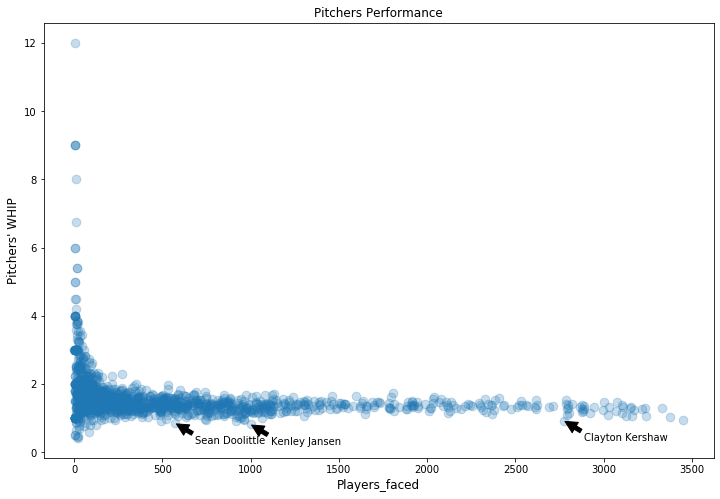

In [30]:
#-----製作投手表現圖表----

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(pitcher_whip.Players_faced, pitcher_whip.WHIP, s=75, alpha=.25)
ax.set_title('Pitchers Performance')
ax.set_xlabel("Players_faced",fontsize=12,)
ax.set_ylabel("Pitchers' WHIP",fontsize=12,)

pitcher_rank = 3 #決定找前幾名的資料

best_whip_pitcher = pitcher_whip_sort.head(rank).reset_index(drop=True)

for i in range(rank):
    value_Players_faced = best_whip_pitcher.loc[i,'Players_faced']
    value_WHIP = best_whip_pitcher.loc[i,'WHIP']
    ax.annotate(best_whip_pitcher.loc[i,'Pitcher'], xy=(value_Players_faced, value_WHIP)\
                ,textcoords='offset points'\
                ,xytext=(+20, -20)\
                ,arrowprops=dict(facecolor='black', shrink=0.05)) #arrowprops設定箭頭
    
#----annotate用法：textcoords表示文字會根據數值位置調整；xytext設定文字位置；arrowprops設定箭頭----
    
#best_whip_pitcher

plt.savefig("Pitchers Performance.png")

In [31]:
#-----計算左右投WHIP-----
at_bats_pitcher_hand = at_bats_pitcher.groupby(['p_throws', 'on_or_off'])['count'].count().reset_index()
at_bats_pitcher_hand

,p_throws,on_or_off,count
0,L,off,358
1,L,on,357
2,R,off,971
3,R,on,956


In [32]:
#-----計算打者表現-----
#-----合併打者名字-----

atbats_batter = pd.merge(atbats, batter_name)

atbats_batter.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,on_or_off,batter_name
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True,off,Matt Carpenter
1,2015000014,572761,Single,201500001,2,2,0,L,452657,L,True,on,Matt Carpenter
2,2015000035,572761,Single,201500001,5,0,0,L,452657,L,True,on,Matt Carpenter
3,2015000048,572761,Groundout,201500001,6,3,0,R,435400,L,True,off,Matt Carpenter
4,2015000069,572761,Flyout,201500001,9,1,0,R,444468,L,True,off,Matt Carpenter


In [33]:
#-----挑出需要的欄位------

at_bats_batter = atbats_batter.groupby(['batter_name','on_or_off']).ab_id.count().reset_index()

at_bats_batter.rename(columns = {'ab_id':'count'}, inplace = True)

at_bats_batter.head()

,batter_name,on_or_off,count
0,A.J. Burnett,off,47
1,A.J. Burnett,on,5
2,A.J. Cole,off,25
3,A.J. Cole,on,5
4,A.J. Ellis,off,515


In [34]:
#-----打者名字整理成list後續Forloup使用-----

batter_list = at_bats_batter.batter_name.drop_duplicates().tolist() #打者名字整理成list
#batter_list

In [35]:
#-----計算所有打者OBP-----

obp = {}
batter_without_on_or_off = []

for i in batter_list:
    df_batter = at_bats_batter[at_bats_batter.batter_name == i]
    if len(df_batter.batter_name)==2:    #處理有些打者只有出局或是只有上壘的情況
        value_off = df_batter[df_batter.on_or_off == 'off'].reset_index().loc[0, 'count']
        value_on = df_batter[df_batter.on_or_off == 'on'].reset_index().loc[0, 'count']
        value = round(value_on / (value_off+value_on), 3) #計算上壘率
        total_count = value_off+value_on #計算總打席數
        obp[i] = str(value)+','+str(total_count) #做成dictionary，後續再將OBP和打席數拆開
    else:
        batter_without_on_or_off.append(i)

In [36]:
batter_obp = pd.DataFrame(list(obp.items()), columns=['Batter', 'OBP'])

batter_obp['PA'] = batter_obp.OBP.apply(lambda x: int(str(x).split(',')[-1])) #把PA和OBP拆開
batter_obp['OBP'] = batter_obp.OBP.apply(lambda x:float(str(x).split(',')[0]))


batter_obp_sort = batter_obp[batter_obp.PA>500].sort_values(by='OBP', ascending=False) #根據OBP做排序
batter_obp_sort.head() 

,Batter,OBP,PA
670,Joey Votto,0.421,2705
956,Mike Trout,0.408,2479
14,Aaron Judge,0.386,1273
159,Brandon Nimmo,0.385,834
195,Bryce Harper,0.383,2476


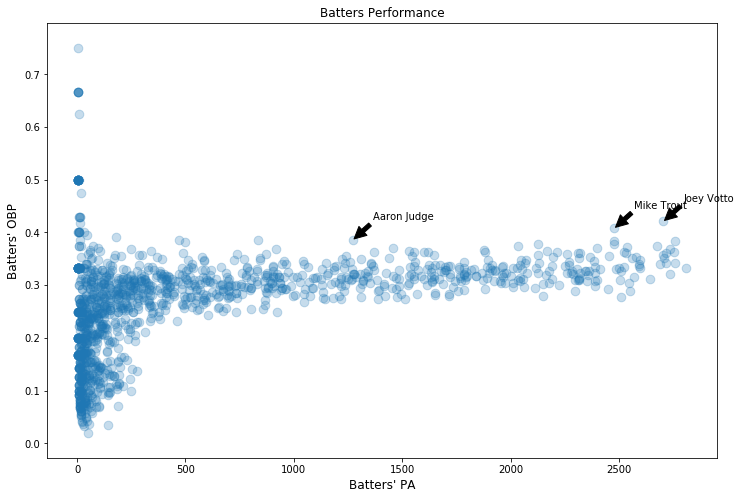

In [37]:
#-----製作打者表現圖表----

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(batter_obp.PA, batter_obp.OBP, s=75, alpha=.25)
ax.set_title('Batters Performance')
ax.set_xlabel("Batters' PA",fontsize=12,)
ax.set_ylabel("Batters' OBP",fontsize=12,)

batter_rank = 3 #決定找前幾名的資料

max_obp_palyer = batter_obp_sort.head(rank).reset_index()

for i in range(rank):
    value_PA = max_obp_palyer.loc[i,'PA']
    value_OBP = max_obp_palyer.loc[i,'OBP']
    ax.annotate(max_obp_palyer.loc[i,'Batter']\
                ,xy=(value_PA, value_OBP)\
                ,textcoords='offset points'\
                ,xytext=(+20, +20)\
                ,arrowprops=dict(facecolor='black', shrink=0.05)) #xytext設定文字位置；arrowprops設定箭頭
    
plt.savefig("Batters Performance.png")

In [38]:
#----載入新的資料----

pitches_original = pd.read_csv('mlb-pitch-data-20152018/pitches.csv')

pitches = pitches_original[['code', 'type', 'pitch_type', 'b_score', 'ab_id','b_count', 's_count', 'outs']] #挑選需要的欄位

pitches.head()

,code,type,pitch_type,b_score,ab_id,b_count,s_count,outs
0,C,S,FF,0.0,2.015000e+09,0.0,0.0,0.0
1,S,S,FF,0.0,2.015000e+09,0.0,1.0,0.0
2,F,S,FF,0.0,2.015000e+09,0.0,2.0,0.0
3,B,B,FF,0.0,2.015000e+09,0.0,2.0,0.0
4,B,B,CU,0.0,2.015000e+09,1.0,2.0,0.0


In [39]:
pitches['ab_id'] = pitches['ab_id'].apply(lambda x:int(str(x)[0:10])) #處理ab_id位數過多問題

pitches.head(10)

/Users/richard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,code,type,pitch_type,b_score,ab_id,b_count,s_count,outs
0,C,S,FF,0.0,2015000001,0.0,0.0,0.0
1,S,S,FF,0.0,2015000001,0.0,1.0,0.0
2,F,S,FF,0.0,2015000001,0.0,2.0,0.0
3,B,B,FF,0.0,2015000001,0.0,2.0,0.0
4,B,B,CU,0.0,2015000001,1.0,2.0,0.0
5,X,X,FF,0.0,2015000001,2.0,2.0,0.0
6,B,B,FF,0.0,2015000002,0.0,0.0,1.0
7,D,X,FC,0.0,2015000002,1.0,0.0,1.0
8,B,B,FF,0.0,2015000003,0.0,0.0,1.0
9,B,B,FF,0.0,2015000003,1.0,0.0,1.0


In [44]:
#---找特定投手的投球結果---

specific_pitcher_name = 'Clayton Kershaw'

atbats_specific_pitcher = atbats_pitcher[atbats_pitcher.pitcher_name == specific_pitcher_name]

atbats_specific_pitcher_abid = atbats_specific_pitcher.ab_id.tolist() #挑出與該選手有關的abid

In [45]:
#----篩選出跟該名選手有關的逐球紀錄----

pitches_specific_pitcher = pd.DataFrame(columns = ['code', 'type', 'pitch_type', 'b_score', 'ab_id','b_count', 's_count', 'outs'])

for i in atbats_specific_pitcher_abid:
    pitches_specific_pitcher = pitches_specific_pitcher.append(pitches[pitches.ab_id==i])
    
pitches_specific_pitcher.head()

,code,type,pitch_type,b_score,ab_id,b_count,s_count,outs
2895,F,S,FF,0.0,2015000768,0.0,0.0,0.0
2896,C,S,FF,0.0,2015000768,0.0,1.0,0.0
2897,H,B,FF,0.0,2015000768,0.0,2.0,0.0
2898,B,B,FF,0.0,2015000769,0.0,0.0,0.0
2899,C,S,FF,0.0,2015000769,1.0,0.0,0.0


In [46]:
#---計算各球種使用比例---

pitches_groupby_type = pitches_specific_pitcher.groupby('pitch_type').code.count().reset_index()

pitches_groupby_type.rename(columns = {'code':'total_count'}, inplace = True) 

pitches_groupby_type['usage'] = pitches_groupby_type['total_count'].apply(lambda x: '%.2f%%' %(x/ pitches_groupby_type['total_count'].sum()*100))

pitches_groupby_type

,pitch_type,total_count,usage
0,CH,51,0.50%
1,CU,1737,16.94%
2,FF,4873,47.53%
3,FT,153,1.49%
4,IN,4,0.04%
5,SL,3435,33.50%


In [47]:
#---逐球紀錄新增上壘與否---

abid_on_or_off = atbats[['ab_id', 'on_or_off']]

pitches_in_progress = pd.DataFrame(columns = ['code', 'type', 'pitch_type', 'b_score', 'ab_id','b_count', 's_count', 'outs', 'on_or_off'])

for i in atbats_specific_pitcher_abid:
    df = pitches_specific_pitcher[pitches_specific_pitcher.ab_id == i]
    df['on_or_off'] = abid_on_or_off[abid_on_or_off.ab_id == i].reset_index().loc[0, 'on_or_off']
    pitches_in_progress = pitches_in_progress.append(df)
    
pitches_in_progress.head()

/Users/richard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,code,type,pitch_type,b_score,ab_id,b_count,s_count,outs,on_or_off
2895,F,S,FF,0.0,2015000768,0.0,0.0,0.0,on
2896,C,S,FF,0.0,2015000768,0.0,1.0,0.0,on
2897,H,B,FF,0.0,2015000768,0.0,2.0,0.0,on
2898,B,B,FF,0.0,2015000769,0.0,0.0,0.0,off
2899,C,S,FF,0.0,2015000769,1.0,0.0,0.0,off


In [48]:
#---挑出inplay的球數---

pitcher_in_play = pd.DataFrame(columns = ['code', 'type', 'pitch_type', 'b_score', 'ab_id','b_count', 's_count', 'outs', 'on_or_off'])

for i in atbats_specific_pitcher_abid:
    df = pitches_in_progress[pitches_in_progress.ab_id == i].reset_index()
    if len(df.ab_id) != 0:
        df_in_play = df.loc[len(df.ab_id)-1,:]
        pitcher_in_play = pitcher_in_play.append(df_in_play)
        
        

In [49]:
#---把所有inplay根據球種作區分---

pitcher_in_play_groupby = pitcher_in_play.groupby(['pitch_type', 'on_or_off']).code.count().reset_index()

pitcher_in_play_groupby.rename(columns = {'code':'count'}, inplace = True) 

pitcher_in_play_groupby

,pitch_type,on_or_off,count
0,CH,off,9
1,CH,on,3
2,CU,off,417
3,CU,on,70
4,FF,off,881
5,FF,on,357
6,FT,off,30
7,FT,on,15
8,IN,off,1
9,SL,off,761


In [50]:
#---新增percentage欄位---

pitcher_in_play_groupby['percentage_int'] = \
pitcher_in_play_groupby.apply(lambda row:'%.2f%%' %(row['count'] / pitcher_in_play_groupby['count']\
                                                   [pitcher_in_play_groupby.pitch_type == row.pitch_type].sum()*100),axis=1)
                             
    
pitcher_in_play_groupby['percentage'] = \
pitcher_in_play_groupby.apply(lambda row: row['count'] / pitcher_in_play_groupby['count']\
                                                   [pitcher_in_play_groupby.pitch_type == row.pitch_type].sum(),axis=1)

pitcher_in_play_groupby



,pitch_type,on_or_off,count,percentage_int,percentage
0,CH,off,9,75.00%,0.750000
1,CH,on,3,25.00%,0.250000
2,CU,off,417,85.63%,0.856263
3,CU,on,70,14.37%,0.143737
4,FF,off,881,71.16%,0.711632
5,FF,on,357,28.84%,0.288368
6,FT,off,30,66.67%,0.666667
7,FT,on,15,33.33%,0.333333
8,IN,off,1,100.00%,1.000000
9,SL,off,761,78.86%,0.788601


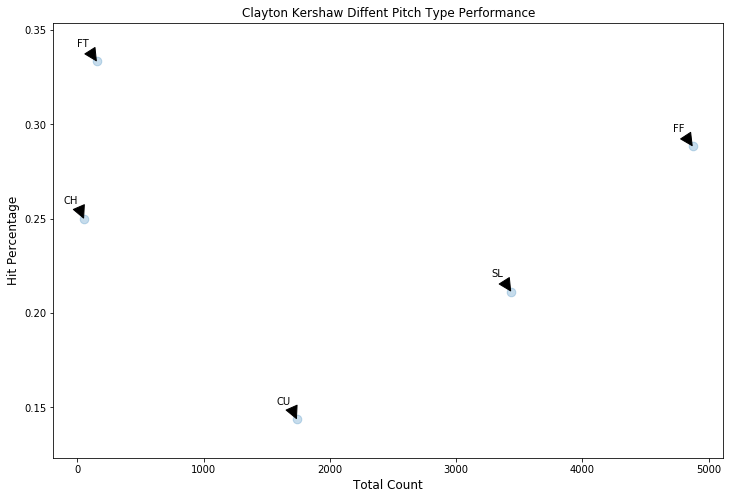

In [51]:
#---根據總投球數與被上壘率做圖---

pitcher_total_count = pd.merge(pitcher_in_play_groupby, pitches_groupby_type, how = 'left', on='pitch_type') #新增總投球數

pitcher_safe_play = pitcher_total_count[pitcher_total_count.on_or_off == 'on'].reset_index()
#jenson_safe_play

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(pitcher_safe_play['total_count'], pitcher_safe_play['percentage'], s=75, alpha=.25)
ax.set_title(specific_pitcher_name+' Diffent Pitch Type Performance')
ax.set_xlabel('Total Count',fontsize=12)
ax.set_ylabel("Hit Percentage",fontsize=12)


for i in range(len(pitcher_safe_play['count'])):
    value_total_count = pitcher_safe_play.loc[i,'total_count']
    value_percentage = pitcher_safe_play.loc[i,'percentage']
    ax.annotate(pitcher_safe_play.loc[i,'pitch_type']\
                ,xy=(value_total_count, value_percentage)\
                ,textcoords='offset points'\
                ,xytext=(-20, +15)\
                ,arrowprops=dict(facecolor='black', shrink=0.05)) #xytext設定文字位置；arrowprops設定箭頭
    
plt.savefig("Top Pitcher Performance.png")

In [52]:
#---找特定打者的打擊狀況---

specific_batter_name = 'Mike Trout'

atbats_specific_batter = atbats_batter[atbats_batter.batter_name == specific_batter_name]

atbats_specific_batter_abid = atbats_specific_batter.ab_id.tolist()

atbats_specific_batter.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,on_or_off,batter_name
29631,2015000077,545361,Home Run,201500002,1,1,0,R,433587,R,True,on,Mike Trout
29632,2015000099,545361,Strikeout,201500002,4,1,2,R,433587,R,True,off,Mike Trout
29633,2015000117,545361,Strikeout,201500002,6,2,4,R,433587,R,True,off,Mike Trout
29634,2015000134,545361,Strikeout,201500002,8,3,4,R,605476,R,True,off,Mike Trout
29635,2015001066,545361,Flyout,201500016,1,2,0,L,572020,R,True,off,Mike Trout


In [53]:
#----篩選出跟該名選手有關的逐球紀錄----

pitches_specific_batter = pd.DataFrame(columns = ['code', 'type', 'pitch_type', 'b_score', 'ab_id','b_count', 's_count', 'outs'])

for i in atbats_specific_batter_abid:
    pitches_specific_batter = pitches_specific_batter.append(pitches[pitches.ab_id==i])
    
pitches_specific_batter.head()

,code,type,pitch_type,b_score,ab_id,b_count,s_count,outs
317,F,S,SI,0.0,2015000077,0.0,0.0,1.0
318,C,S,FF,0.0,2015000077,0.0,1.0,1.0
319,B,B,SI,0.0,2015000077,0.0,2.0,1.0
320,F,S,SI,0.0,2015000077,1.0,2.0,1.0
321,F,S,SI,0.0,2015000077,1.0,2.0,1.0


In [54]:
#---計算不同球種出局狀況---

batter_in_progress = pd.DataFrame(columns = ['code', 'type', 'pitch_type', 'b_score', 'ab_id','b_count', 's_count', 'outs', 'on_or_off'])

for i in atbats_specific_batter_abid:
    df_batter = pitches_specific_batter[pitches_specific_batter.ab_id == i]
    df_batter['on_or_off'] = abid_on_or_off[abid_on_or_off.ab_id == i].reset_index().loc[0, 'on_or_off']
    batter_in_progress = batter_in_progress.append(df_batter)
    
batter_in_progress.head()

/Users/richard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,code,type,pitch_type,b_score,ab_id,b_count,s_count,outs,on_or_off
317,F,S,SI,0.0,2015000077,0.0,0.0,1.0,on
318,C,S,FF,0.0,2015000077,0.0,1.0,1.0,on
319,B,B,SI,0.0,2015000077,0.0,2.0,1.0,on
320,F,S,SI,0.0,2015000077,1.0,2.0,1.0,on
321,F,S,SI,0.0,2015000077,1.0,2.0,1.0,on


In [55]:
#---挑出inplay的球數---

batter_in_play = pd.DataFrame(columns = ['code', 'type', 'pitch_type', 'b_score', 'ab_id','b_count', 's_count', 'outs', 'on_or_off'])

for i in atbats_specific_batter_abid:
    df_batter_1 = batter_in_progress[batter_in_progress.ab_id == i].reset_index()
    if len(df_batter_1.ab_id) != 0:
        df_batter_in_play = df_batter_1.loc[len(df_batter_1.ab_id)-1,:]
        batter_in_play = batter_in_play.append(df_batter_in_play)

batter_in_play.head()
        

,code,type,pitch_type,b_score,ab_id,b_count,s_count,outs,on_or_off,index
7,E,X,SI,0.0,2015000077,2.0,2.0,1.0,on,324.0
5,W,S,CH,1.0,2015000099,2.0,2.0,0.0,off,408.0
3,S,S,SI,1.0,2015000117,1.0,2.0,1.0,off,477.0
3,T,S,SI,1.0,2015000134,1.0,2.0,2.0,off,541.0
1,X,X,FF,0.0,2015001066,1.0,0.0,1.0,off,4046.0


In [56]:
#---把所有inplay根據球種作區分---

batter_in_play_groupby = batter_in_play.groupby(['pitch_type', 'on_or_off']).code.count().reset_index()

batter_in_play_groupby.rename(columns = {'code':'count'}, inplace = True) 

batter_in_play_groupby

,pitch_type,on_or_off,count
0,CH,off,131
1,CH,on,86
2,CU,off,87
3,CU,on,47
4,FC,off,78
5,FC,on,73
6,FF,off,464
7,FF,on,398
8,FS,off,26
9,FS,on,18


In [57]:
batter_in_play_groupby['percentage_int'] = \
batter_in_play_groupby.apply(lambda row:'%.2f%%' %(row['count'] / batter_in_play_groupby['count']\
                                                   [batter_in_play_groupby.pitch_type == row.pitch_type].sum()*100),axis=1)
                             
    
batter_in_play_groupby['percentage'] = \
batter_in_play_groupby.apply(lambda row: row['count'] / batter_in_play_groupby['count']\
                                                   [batter_in_play_groupby.pitch_type == row.pitch_type].sum(),axis=1)

batter_in_play_groupby

,pitch_type,on_or_off,count,percentage_int,percentage
0,CH,off,131,60.37%,0.603687
1,CH,on,86,39.63%,0.396313
2,CU,off,87,64.93%,0.649254
3,CU,on,47,35.07%,0.350746
4,FC,off,78,51.66%,0.516556
5,FC,on,73,48.34%,0.483444
6,FF,off,464,53.83%,0.538283
7,FF,on,398,46.17%,0.461717
8,FS,off,26,59.09%,0.590909
9,FS,on,18,40.91%,0.409091


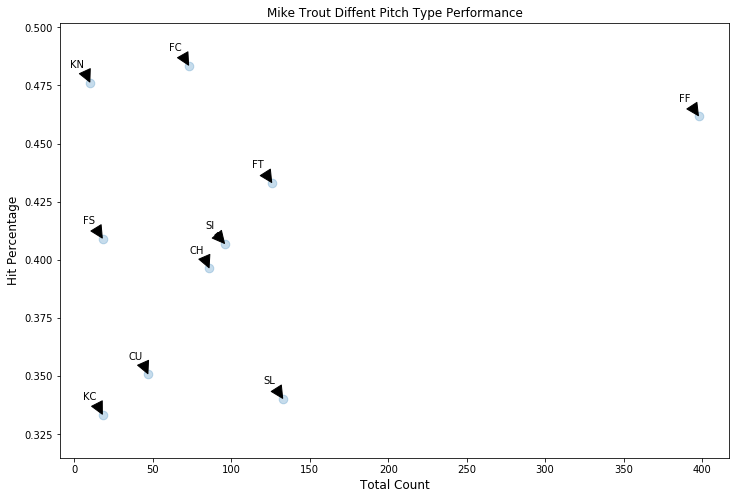

In [58]:
#---根據面對投球數與上壘率做圖---

batter_safe_play = batter_in_play_groupby[batter_in_play_groupby.on_or_off == 'on'].reset_index()

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(batter_safe_play['count'], batter_safe_play['percentage'], s=75, alpha=.25)
ax.set_title(specific_batter_name+' Diffent Pitch Type Performance')
ax.set_xlabel('Total Count',fontsize=12)
ax.set_ylabel("Hit Percentage",fontsize=12)


for i in range(len(batter_safe_play['count'])):
    value_total_count = batter_safe_play.loc[i,'count']
    value_percentage = batter_safe_play.loc[i,'percentage']
    ax.annotate(batter_safe_play.loc[i,'pitch_type']\
                ,xy=(value_total_count, value_percentage)\
                ,textcoords='offset points'\
                ,xytext=(-20, +15)\
                ,arrowprops=dict(facecolor='black', shrink=0.05)) #xytext設定文字位置；arrowprops設定箭頭
    
plt.savefig("Top Batter Performance.png")